# Prithvi 100M model
This notebook will demonstrate basic usage of the Prithvi ViT model.

## Getting started with Prithvi - Reconstruction
### Get model files

To get started, clone the HuggingFace repository for Prithvi 100M, running the command below

```bash
# Make sure you have git-lfs installed (https://git-lfs.com)
git lfs install
git clone https://huggingface.co/ibm-nasa-geospatial/Prithvi-100M
# rename to a valid python module name
mv Prithvi-100M prithvi
```

Alternatively, you can directly download the [weights](https://huggingface.co/ibm-nasa-geospatial/Prithvi-100M/tree/main#:~:text=Prithvi_100M.pt,pickle) and [model class](https://huggingface.co/ibm-nasa-geospatial/Prithvi-100M/blob/main/Prithvi.py) and [configuration file](https://huggingface.co/ibm-nasa-geospatial/Prithvi-100M/blob/main/Prithvi_100M_config.yaml) from the repository and place them inside a directory named`prithvi`.

A third alternative is to leverage the `huggingface_hub` library to download these files directly through code.
`%pip install huggingface_hub`

### Treat it as a module
Next, lets add an `__init__.py` file to the downloaded directory, so we can treat it as a module and import the `MaskedAutoencoderViT` class from it.
Simply create an empty file inside the `prithvi` directory named `__init__.py` by running the code below

In [1]:
with open("prithvi/__init__.py", "w") as f:
    f.write("")

### Relevant imports
To run this notebook, besides following the installation steps in the [README](./README.md), make sure to install [jupyter](https://jupyter.org/install)

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import yaml
from prithvi.Prithvi import MaskedAutoencoderViT

NO_DATA = -9999
NO_DATA_FLOAT = 0.0001
PERCENTILES = (0.1, 99.9)

/Users/cpi/opt/miniconda3/envs/hls-of/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define some functions for visualization

In [2]:
def load_raster(path, crop=None):
    with rasterio.open(path) as src:
        img = src.read()

        # load first 6 bands
        img = img[:6]

        img = np.where(img == NO_DATA, NO_DATA_FLOAT, img)
        if crop:
            img = img[:, -crop[0]:, -crop[1]:]
    return img

def enhance_raster_for_visualization(raster, ref_img=None):
    if ref_img is None:
        ref_img = raster
    channels = []
    for channel in range(raster.shape[0]):
        valid_mask = np.ones_like(ref_img[channel], dtype=bool)
        valid_mask[ref_img[channel] == NO_DATA_FLOAT] = False
        mins, maxs = np.percentile(ref_img[channel][valid_mask], PERCENTILES)
        normalized_raster = (raster[channel] - mins) / (maxs - mins)
        normalized_raster[~valid_mask] = 0
        clipped = np.clip(normalized_raster, 0, 1)
        channels.append(clipped)
    clipped = np.stack(channels)
    channels_last = np.moveaxis(clipped, 0, -1)[..., :3]
    rgb = channels_last[..., ::-1]
    return rgb

In [3]:
def plot_image_mask_reconstruction(normalized, mask_img, pred_img):
    # Mix visible and predicted patches
    rec_img = normalized.clone()
    rec_img[mask_img == 1] = pred_img[mask_img == 1]  # binary mask: 0 is keep, 1 is remove

    mask_img_np = mask_img.numpy().reshape(6, 224, 224).transpose((1, 2, 0))[..., :3]

    rec_img_np = (rec_img.numpy().reshape(6, 224, 224) * stds) + means
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))

    for subplot in ax:
        subplot.axis('off')

    ax[0].imshow(enhance_raster_for_visualization(input_data))
    masked_img_np = enhance_raster_for_visualization(input_data).copy()
    masked_img_np[mask_img_np[..., 0] == 1] = 0
    ax[1].imshow(masked_img_np)
    ax[2].imshow(enhance_raster_for_visualization(rec_img_np, ref_img=input_data))

### Loading the model
Assuming you have the relevant files under this directory

In [4]:
# load weights
weights_path = "./prithvi/Prithvi_100M.pt"
checkpoint = torch.load(weights_path, map_location="cpu")

# read model config
model_cfg_path = "./prithvi/Prithvi_100M_config.yaml"
with open(model_cfg_path) as f:
    model_config = yaml.safe_load(f)

model_args, train_args = model_config["model_args"], model_config["train_params"]

# let us use only 1 frame for now (the model was trained on 3 frames)
model_args["num_frames"] = 1

# instantiate model
model = MaskedAutoencoderViT(**model_args)
model.eval()

# load weights into model
# strict=false since we are loading with only 1 frame, but the warning is expected
del checkpoint['pos_embed']
del checkpoint['decoder_pos_embed']
_ = model.load_state_dict(checkpoint, strict=False)

### Let's try it out!
We can access the images directly from the HuggingFace space thanks to rasterio

Input data shape is (6, 224, 224)


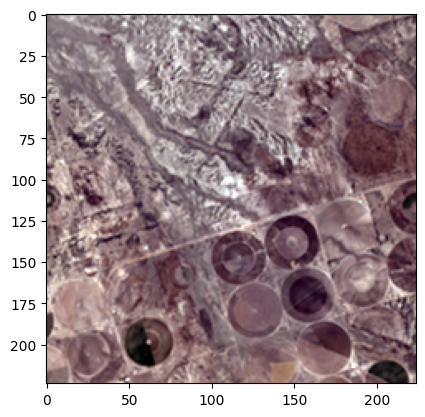

In [5]:
raster_path = "https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-demo/resolve/main/HLS.L30.T13REN.2018013T172747.v2.0.B02.B03.B04.B05.B06.B07_cropped.tif"
input_data = load_raster(raster_path, crop=(224, 224))
print(f"Input data shape is {input_data.shape}")
raster_for_visualization = enhance_raster_for_visualization(input_data)
plt.imshow(raster_for_visualization)

#### Lets call the model!
We pass:
 - The normalized input image, cropped to size (224, 224)
 - `mask_ratio`: The proportion of pixels that will be masked

The model returns a tuple with:
 - loss
 - reconstructed image
 - mask used

In [6]:
# statistics used to normalize images before passing to the model
means = np.array(train_args["data_mean"]).reshape(-1, 1, 1)
stds = np.array(train_args["data_std"]).reshape(-1, 1, 1)

def preprocess_image(image):
    # normalize image
    normalized = image.copy()
    normalized = ((image - means) / stds)
    normalized = torch.from_numpy(normalized.reshape(1, normalized.shape[0], 1, *normalized.shape[-2:])).to(torch.float32)
    return normalized

In [7]:
normalized = preprocess_image(input_data)
with torch.no_grad():
        mask_ratio = 0.5
        _, pred, mask = model(normalized, mask_ratio=mask_ratio)
        mask_img = model.unpatchify(mask.unsqueeze(-1).repeat(1, 1, pred.shape[-1])).detach().cpu()
        pred_img = model.unpatchify(pred).detach().cpu()

#### Lets use these to build a nice output visualization

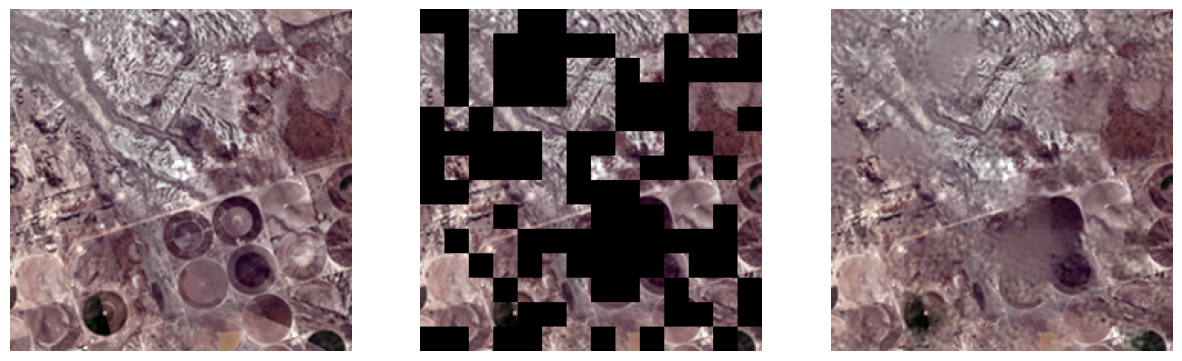

In [8]:
plot_image_mask_reconstruction(normalized, mask_img, pred_img)

## Inference with finetuned Prithvi

#### Let's explore a finetuned example - Flood Segmentation

This time, lets use the huggingface hub library to directly download the files for the finetuned model.

In [10]:
%pip install huggingface_hub

Note: you may need to restart the kernel to use updated packages.


In [9]:
from mmcv import Config
from mmseg.models import build_segmentor
from mmseg.datasets.pipelines import Compose, LoadImageFromFile
from mmseg.apis import init_segmentor
from model_inference import inference_segmentor, process_test_pipeline
from huggingface_hub import hf_hub_download
import matplotlib
from torch import nn

In [10]:
# Grab the config and model weights from huggingface
config_path=hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-100M-sen1floods11", filename="sen1floods11_Prithvi_100M.py")
ckpt=hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-100M-sen1floods11", filename='sen1floods11_Prithvi_100M.pth')
finetuned_model = init_segmentor(Config.fromfile(config_path), ckpt, device="cpu")

/Users/cpi/opt/miniconda3/envs/hls-of/lib/python3.9/site-packages/mmseg/models/decode_heads/decode_head.py:104: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert seg_logist into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/Users/cpi/opt/miniconda3/envs/hls-of/lib/python3.9/site-packages/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: /Users/cpi/.cache/huggingface/hub/models--ibm-nasa-geospatial--Prithvi-100M-sen1floods11/snapshots/220f62f00f6a31a70daac7babf139e4bf265f1c0/sen1floods11_Prithvi_100M.pth


### Let's grab an image to do inference on

In [13]:
!wget https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-sen1floods11-demo/resolve/main/Spain_7370579_S2Hand.tif

--2023-11-10 13:14:08--  https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-sen1floods11-demo/resolve/main/Spain_7370579_S2Hand.tif
Resolving huggingface.co (huggingface.co)... 18.165.183.98, 18.165.183.110, 18.165.183.94, ...
Connecting to huggingface.co (huggingface.co)|18.165.183.98|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/f5/58/f558b73cabb08f1c54cb2db126d55670236aeb76a5eac5a5e63e5fb296eb1f5a/16e997e6a7159fa11160faf00591da763eb37ac82faf806f7fe733991944a048?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27Spain_7370579_S2Hand.tif%3B+filename%3D%22Spain_7370579_S2Hand.tif%22%3B&response-content-type=image%2Ftiff&Expires=1699877650&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTY5OTg3NzY1MH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy9mNS81OC9mNTU4YjczY2FiYjA4ZjFjNTRjYjJkYjEyNmQ1NTY3MDIzNmFlYjc2YTVlYWM1YTVlNjNlNWZiMjk2ZWIxZ

Image input shape is (6, 512, 512)


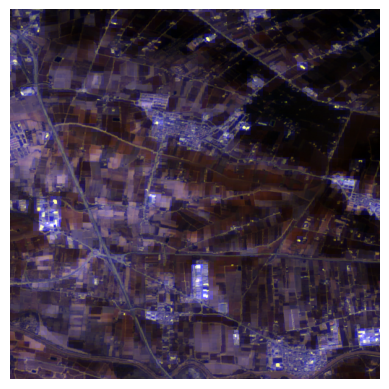

In [11]:
input_data_inference = load_raster("Spain_7370579_S2Hand.tif")
print(f"Image input shape is {input_data_inference.shape}")
raster_for_visualization = enhance_raster_for_visualization(input_data_inference)
plt.axis('off')
plt.imshow(raster_for_visualization)

In [12]:
# adapt this pipeline for Tif files with > 3 images
custom_test_pipeline = process_test_pipeline(finetuned_model.cfg.data.test.pipeline)
result = inference_segmentor(finetuned_model, "Spain_7370579_S2Hand.tif", custom_test_pipeline=custom_test_pipeline)

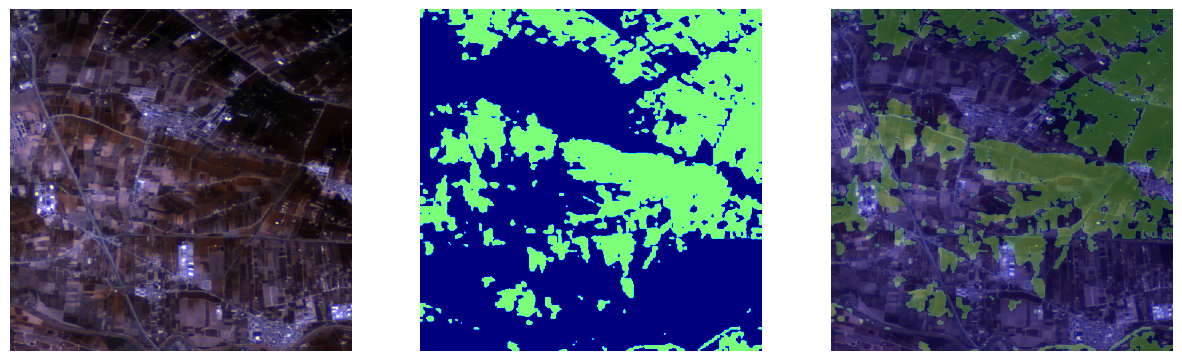

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
input_data_inference = load_raster("Spain_7370579_S2Hand.tif")
norm = matplotlib.colors.Normalize(vmin=0, vmax=2)
ax[0].imshow(enhance_raster_for_visualization(input_data_inference))
ax[1].imshow(result[0], norm=norm, cmap="jet")
ax[2].imshow(enhance_raster_for_visualization(input_data_inference))
ax[2].imshow(result[0], cmap="jet", alpha=0.3, norm=norm)
for subplot in ax:
    subplot.axis('off')

## Finetuning for your use case
To finetune, you can now write a PyTorch loop as usual to train on your dataset. Simply extract the backbone from the model with some surgery and run only the model features forward, with no masking!

 In general some reccomendations are:
- At least in the beggining, experiment with freezing the backbone. This will give you much faster iteration through experiments.
- Err on the side of a smaller learning rate
- With an unfrozen encoder, regularization is your friend! (Weight decay, dropout, batchnorm...)

In [14]:
# if going with plain pytorch:
# - remember to normalize images beforehand (find the normalization statistics in the config file)
# - turn off masking by passing mask_ratio = 0
normalized = preprocess_image(input_data)
features, _, _ = model.forward_encoder(normalized, mask_ratio=0)

#### What do these features look like?
These are the standard output of a ViT.
- Dim 1: Batch size
- Dim 2: [`cls_token`] + tokens representing flattened image
- Dim 3: embedding dimension

First reshape features into "image-like" shape:
- Drop cls_token
- reshape into HxW shape

In [15]:
print(f"Encoder features have shape {features.shape}")

# drop cls token
reshaped_features = features[:, 1:, :]

# reshape
feature_img_side_length = int(np.sqrt(reshaped_features.shape[1]))
reshaped_features = reshaped_features.view(-1, feature_img_side_length, feature_img_side_length, model_args["embed_dim"])
# channels first
reshaped_features = reshaped_features.permute(0, 3, 1, 2)
print(f"Encoder features have new shape {reshaped_features.shape}")

Encoder features have shape torch.Size([1, 197, 768])
Encoder features have new shape torch.Size([1, 768, 14, 14])


#### Example of a segmentation head
A simple segmentation head can consist of a few upscaling blocks + a final head for classification

In [16]:
num_classes = 2
upscaling_block = lambda in_channels, out_channels: nn.Sequential(nn.Upsample(scale_factor=2), nn.Conv2d(kernel_size=3, in_channels=in_channels, out_channels=out_channels, padding=1), nn.ReLU())
embed_dims = [model_args["embed_dim"] // (2**i) for i in range(5)]
segmentation_head = nn.Sequential(
    *[
    upscaling_block(embed_dims[i], embed_dims[i+1]) for i in range(4)
    ],
    nn.Conv2d(kernel_size=1, in_channels=embed_dims[-1], out_channels=num_classes))

### Running features through the segmentation head
We now get an output of shape [batch_size, num_classes, height, width]

In [17]:
segmentation_head(reshaped_features).shape

torch.Size([1, 2, 224, 224])

### Finetuning - MMSeg
Alternatively, finetune using the MMSegmentation extension we have opensourced.
- No model surgery required
- No need to write boilerplate training code
- Integrations with Tensorboard, MLFlow, ...
- Segmentation evaluation metrics / losses built in

1. Build your config file. Look [here](./configs/) for examples, the [ReadME](./README.md) for some docs and [MMSeg](https://mmsegmentation.readthedocs.io/en/0.x/tutorials/config.html) for more general tutorials.
2. Collect your dataset in the format determined by MMSeg
3. `mim train mmsegmentation <path to my config>`

This is what the model looks like in the MMSeg configuration code.

All this composition we did above is done for you!
```python
model = dict(
    type="TemporalEncoderDecoder",
    frozen_backbone=False,
    backbone=dict(
        type="TemporalViTEncoder",
        pretrained=pretrained_weights_path,
        img_size=img_size,
        patch_size=patch_size,
        num_frames=num_frames,
        tubelet_size=1,
        in_chans=len(bands),
        embed_dim=embed_dim,
        depth=num_layers,
        num_heads=num_heads,
        mlp_ratio=4.0,
        norm_pix_loss=False,
    ),
    neck=dict(
        type="ConvTransformerTokensToEmbeddingNeck",
        embed_dim=num_frames*embed_dim,
        output_embed_dim=embed_dim,
        drop_cls_token=True,
        Hp=img_size // patch_size,
        Wp=img_size // patch_size,
    ),
    decode_head=dict(
        num_classes=num_classes,
        in_channels=embed_dim,
        type="FCNHead",
        in_index=-1,
        ignore_index=ignore_index,
        channels=256,
        num_convs=1,
        concat_input=False,
        dropout_ratio=0.1,
        norm_cfg=norm_cfg,
        align_corners=False,
        loss_decode=dict(
            type="CrossEntropyLoss",
            use_sigmoid=False,
            loss_weight=1,
            class_weight=ce_weights,
            avg_non_ignore=True
        ),
    ),
    (...)
```